In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import date, timedelta

start = '2021-06-01'
end = '2022-05-27'

start_date = date.fromisoformat(start)
end_date = date.fromisoformat(end)

date_range = [
    (end_date - timedelta(days=i)).strftime('%d-%m-%Y')
    for i
    in range((end_date - start_date).days)
]

In [3]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

cgk_mk_data = {
    'date':[],
    'price':[],
    'mc':[],
    'circ_supply':[]
}

for date in date_range:
    cgk_mk_data['date'].append(date)

    try:
        response_data = cg.get_coin_history_by_id(id='osmosis', date=date, localization=False)['market_data']
        cgk_mk_data['price'].append(response_data['current_price']['usd'])
        cgk_mk_data['mc'].append(response_data['market_cap']['usd'])
        cgk_mk_data['circ_supply'].append(response_data['market_cap']['usd'] / response_data['current_price']['usd'])
    except:
        cgk_mk_data['price'].append(None)
        cgk_mk_data['mc'].append(None)
        cgk_mk_data['circ_supply'].append(None)

In [4]:
df_cgk = pd.DataFrame(data=cgk_mk_data)\
    .dropna(axis=0, how='any')
df_cgk.date = pd.to_datetime(df_cgk.date, format='%d-%m-%Y')
df_cgk.sort_values(by='date', ascending=True, inplace=True)
df_cgk.head()

,date,price,mc,circ_supply
69,2022-03-19,9.186945,2.978328e+09,3.241913e+08
68,2022-03-20,9.298549,3.016520e+09,3.244075e+08
67,2022-03-21,9.044957,2.943091e+09,3.253848e+08
66,2022-03-22,8.842260,2.883337e+09,3.260859e+08
65,2022-03-23,8.674816,2.834337e+09,3.267316e+08


In [12]:
df_flip = pd.read_json('https://node-api.flipsidecrypto.com/api/v2/queries/eb582ce9-3ade-46fe-b1d4-610c39ab82eb/data/latest')\
    .sort_values(by='DATE', ascending=True)
df_flip.columns = df_flip.columns.str.lower()
df_flip.head()

,date,label_action,osmo
639,2021-06-18,STAKE,3.421960e+03
601,2021-06-19,UNSTAKE,1.463607e+04
616,2021-06-19,STAKE,1.368507e+06
137,2021-06-20,STAKE,2.037103e+06
243,2021-06-20,UNSTAKE,4.494845e+04


In [7]:
sns.set_style('darkgrid')

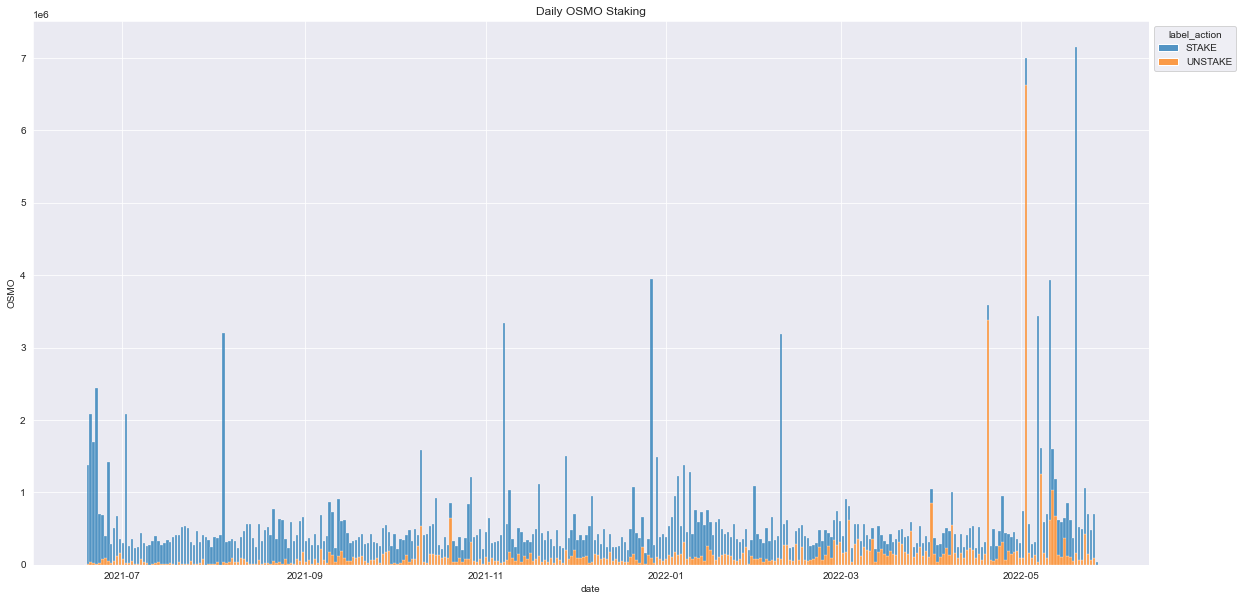

In [87]:
plt.figure(figsize=(20,10))
ax = sns.histplot(df_flip, x='date', hue='label_action', weights='osmo',
             multiple='stack', shrink=0.8, bins=344)
ax.set_ylabel('OSMO')
plt.title('Daily OSMO Staking', loc='center')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

In [19]:
df_cumulative = df_flip[['date','label_action','osmo']].pivot(index='date',columns='label_action',values='osmo')\
    .reset_index()
df_cumulative.fillna(0, inplace=True)
df_cumulative.columns = df_cumulative.columns.str.lower()
df_cumulative['staked_amount'] = df_cumulative.stake - df_cumulative.unstake

df_cumulative['rolling_30'] = df_cumulative.staked_amount.rolling(30).sum()
df_cumulative['rolling_60'] = df_cumulative.staked_amount.rolling(60).sum()
df_cumulative['rolling_90'] = df_cumulative.staked_amount.rolling(90).sum()
df_cumulative['cumulative'] = df_cumulative.staked_amount.cumsum()

df_cumulative = df_cumulative.merge(right=df_cgk, on='date', how='left')\
    .reset_index(drop=True)

df_cumulative['staking_ratio'] = df_cumulative.cumulative / df_cumulative.circ_supply * 100

df_cumulative

,date,stake,unstake,staked_amount,rolling_30,rolling_60,rolling_90,cumulative,price,mc,circ_supply,staking_ratio
0,2021-06-18,3.421960e+03,0.000000,3.421960e+03,NaN,NaN,NaN,3.421960e+03,NaN,NaN,NaN,NaN
1,2021-06-19,1.368507e+06,14636.070020,1.353871e+06,NaN,NaN,NaN,1.357293e+06,NaN,NaN,NaN,NaN
2,2021-06-20,2.037103e+06,44948.452141,1.992154e+06,NaN,NaN,NaN,3.349447e+06,NaN,NaN,NaN,NaN
3,2021-06-21,1.666067e+06,24445.056033,1.641622e+06,NaN,NaN,NaN,4.991068e+06,NaN,NaN,NaN,NaN
4,2021-06-22,2.425673e+06,12517.170998,2.413156e+06,NaN,NaN,NaN,7.404224e+06,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
339,2022-05-23,6.424107e+05,418856.508103,2.235542e+05,1.058230e+07,8.821313e+06,1.005091e+07,1.035114e+08,1.793356,6.759319e+08,3.769090e+08,27.463218
340,2022-05-24,5.448786e+05,152532.326701,3.923462e+05,1.104286e+07,9.541976e+06,1.025691e+07,1.039037e+08,1.771739,6.690345e+08,3.776146e+08,27.515808
341,2022-05-25,4.206447e+05,64328.907407,3.563158e+05,1.106939e+07,9.879316e+06,1.041001e+07,1.042600e+08,1.686672,6.384569e+08,3.785305e+08,27.543356
342,2022-05-26,6.127346e+05,91090.364694,5.216442e+05,1.129001e+07,1.042630e+07,1.099545e+07,1.047817e+08,1.589280,6.030535e+08,3.794507e+08,27.614040


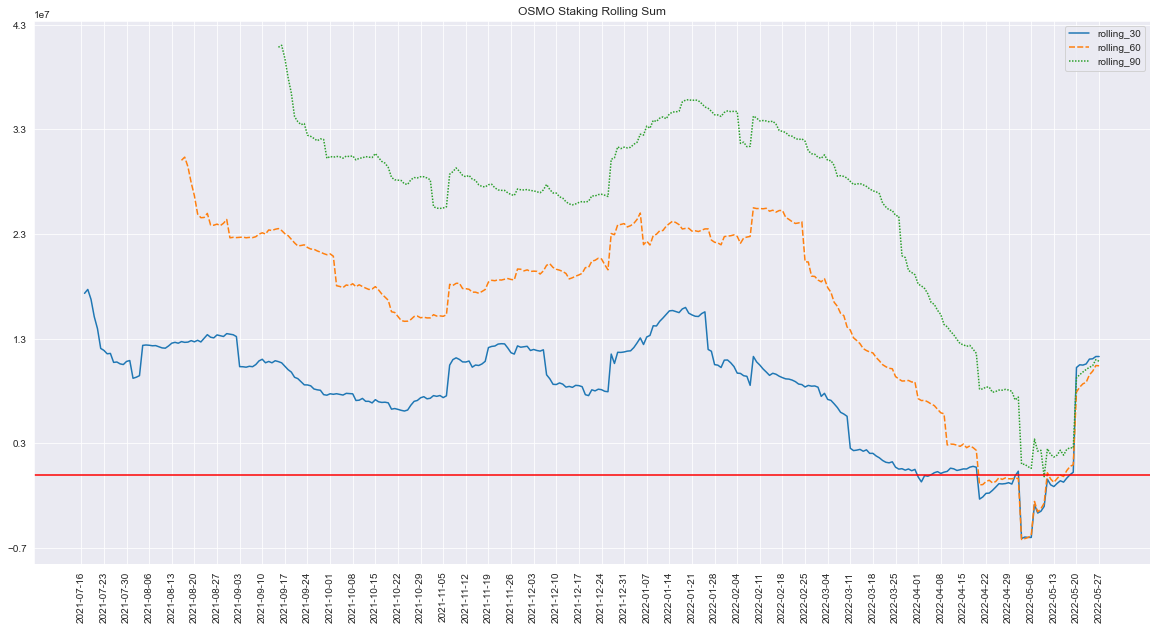

In [96]:
plt.figure(figsize=(20,10))

ax = plt.subplot()

sns.lineplot(data=df_cumulative[['date','rolling_30','rolling_60','rolling_90']])
plt.axhline(0, color='red')
plt.title('OSMO Staking Rolling Sum')

plt.xticks(range(28,344,7), rotation=90)
ax.set_xticklabels([df_cumulative.date[x].strftime('%Y-%m-%d') for x in range(28,344,7)])

plt.yticks(range(-7000000,45000000,10000000))

plt.show()


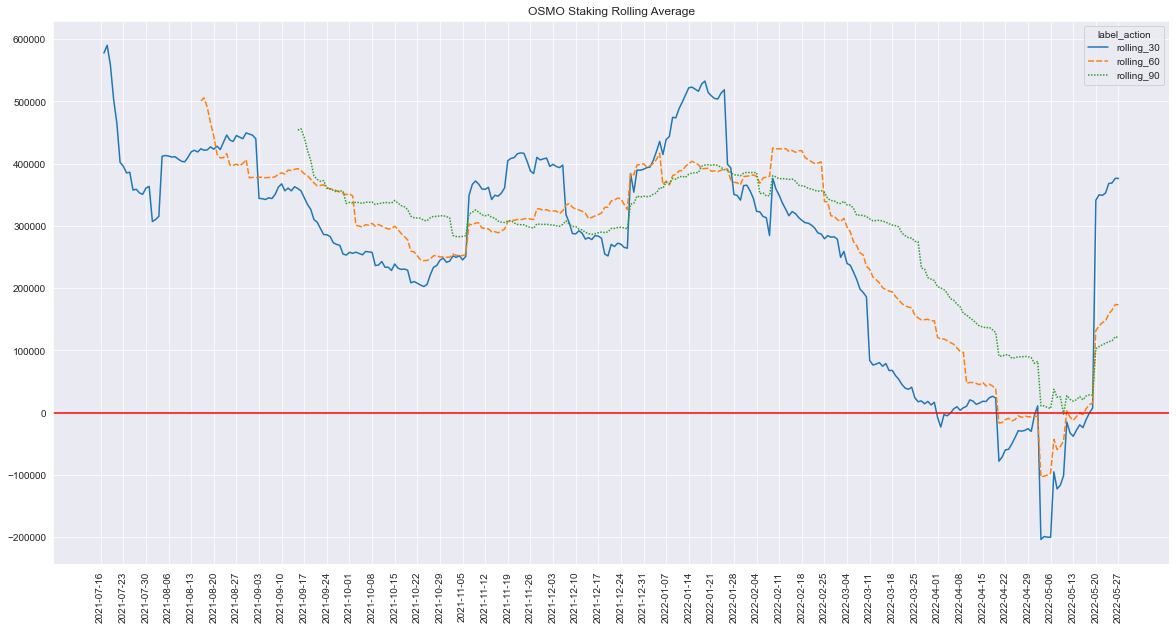

In [92]:
df_rolavg = df_flip[['date','label_action','osmo']].pivot(index='date',columns='label_action',values='osmo')\
    .reset_index()
df_rolavg.fillna(0, inplace=True)
df_rolavg.columns = df_rolavg.columns.str.lower()
df_rolavg['staked_amount'] = df_rolavg.stake - df_rolavg.unstake

df_rolavg['rolling_30'] = df_rolavg.staked_amount.rolling(30).mean()
df_rolavg['rolling_60'] = df_rolavg.staked_amount.rolling(60).mean()
df_rolavg['rolling_90'] = df_rolavg.staked_amount.rolling(90).mean()

plt.figure(figsize=(20,10))

ax = plt.subplot()

sns.lineplot(data=df_rolavg[['date','rolling_30','rolling_60','rolling_90']])
plt.axhline(0, color='red')
plt.title('OSMO Staking Rolling Average')

plt.xticks(range(28,344,7), rotation=90)
ax.set_xticklabels([df_rolavg.date[x].strftime('%Y-%m-%d') for x in range(28,344,7)])

# plt.yticks(range(-7000000,45000000,10000000))
plt.show()


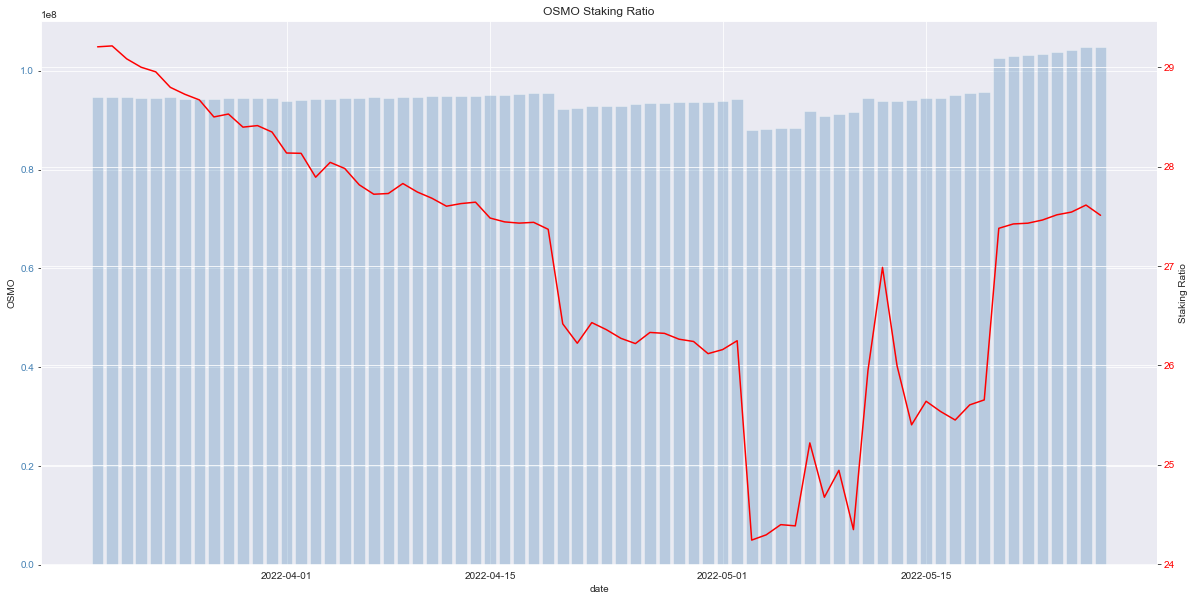

In [89]:
cumulative = df_cumulative[df_cumulative.date >= '2022-03-19'].cumulative
staking_ratio = df_cumulative[df_cumulative.date >= '2022-03-19'].staking_ratio
d = df_cumulative[df_cumulative.date >= '2022-03-19'].date

def two_scales(ax1, date, data1, data2, c1, c2):

    ax2 = ax1.twinx()

    ax1.bar(date, data1, color=c1, alpha=0.3)
    ax1.set_xlabel('date')
    ax1.set_ylabel('OSMO')

    ax2.plot(date, data2, color=c2)
    ax2.set_ylabel('Staking Ratio')
    return ax1, ax2

fig, ax = plt.subplots(figsize=(20,10))
ax1, ax2 = two_scales(ax, d, cumulative, staking_ratio, 'steelblue', 'r')
plt.title('OSMO Staking Ratio')

def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

color_y_axis(ax1, 'steelblue')
color_y_axis(ax2, 'r')

plt.show()

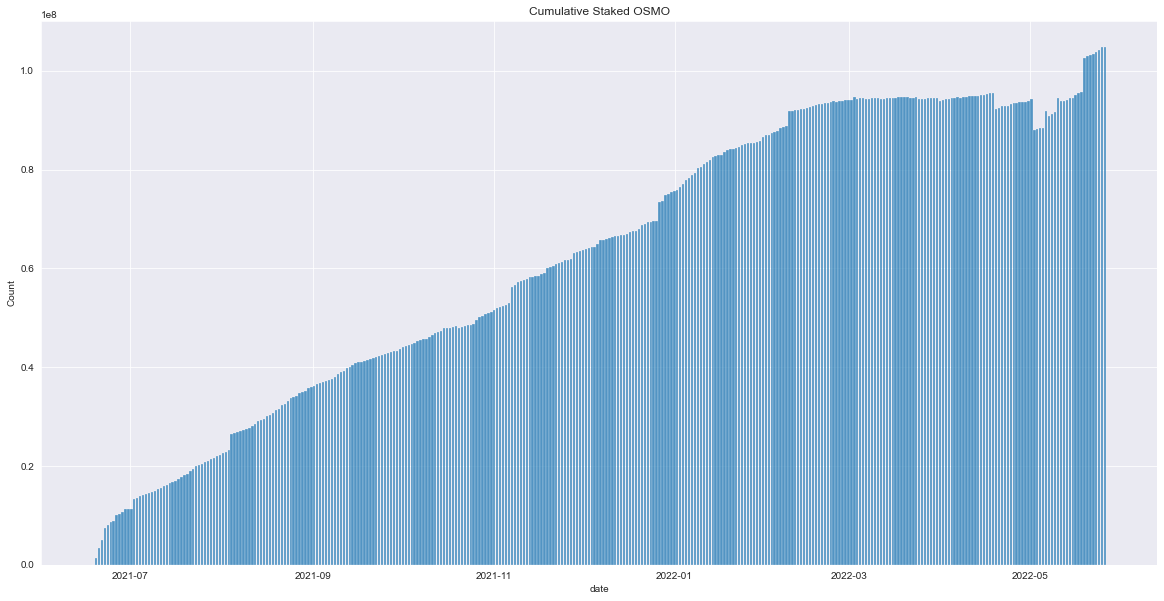

In [85]:
plt.figure(figsize=(20,10))
ax = plt.subplot()
sns.histplot(df_cumulative, x='date', weights='cumulative', shrink=0.8, bins=344)
plt.title('Cumulative Staked OSMO')

plt.show()